# Coding project: Connect4 agent

SASSON Charlotte - BERARD Paul - JEUNOT Xavier - PUJOL Corentin

## Introduction

The assignment is to develop an agent for Connect4, as implemented in the PettingZoo library, using Reinforcement Learning methods.

https://pettingzoo.farama.org/environments/classic/connect_four/

Students need to form groups of 2 or 3 *or 4* students, and will deliver a zip containing the code and a short report on the methods used. Deadline: April 14th.

The report should contain a description of the methods used and a description of the results. Here are a few questions that should be adressed in some way in the report
What design choices did you make in the development of your algorithm?
Describe the training procedure, the structure of the code.
Describe how you chose important hyperparameters, what you understand from their impact.
How did you assess the quality of your agent?
Do you think the approach you implemented would fare well on more complex environments, like backgammon, chess, go, Starcraft?
How would you improve it if given more time or computational power?
Describe also the workflow and how you split the work in the group.


The code should be clear and legible, variables well-named, and commented when helpful for comprehension. The final code should implement a class Player, with a method get_action that takes a state as specified in the PettingZoo environment and returns an integer between 0 and 6.

Performance is not the main point: better to show understanding of the methods you used and their limits.  

Ideas to get started: 
MCTS : https://sites.ualberta.ca/~szepesva/papers/CACM-MCTS.pdf

Eligibility Traces:
https://www.bkgm.com/articles/tesauro/tdl.html
https://www.ai.rug.nl/~mwiering/GROUP/ARTICLES/learning-chess.pdf

## Dependancies handling

In [78]:
# import pip 

# !pip install pettingzoo
# !pip install pygame
# !pip install numpy
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [79]:
from pettingzoo.classic import connect_four_v3

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from copy import deepcopy
import random as rd

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [80]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

print(state)
# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots (1 is legal, 0 is not, thus it means that a column is full)


{'observation': array([[[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=int8), 'action_mask': array([1, 1, 1, 1, 1, 1, 1], dtype=int8)}
(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1

In [81]:
env.reset()
env.step(0)

state, reward, terminated, truncated, info = env.last()


print(
    state["observation"].shape
) 
print(state["observation"][:, :, 0])  
print(state["observation"][:, :, 1])  

print(state["action_mask"])

(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [82]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        # print("Mask before choice :\n", obs_mask["action_mask"])
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        # print("Coups possibles :\n", masked_arr)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [83]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [84]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0) #action -> entier
            #print("Action choisie :\n", action) 
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    # print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                    
                    # print(obs['observation'][:, :, 0])
                    
                    # print(obs['observation'][:, :, 1])
                return i

In [85]:
# agent0 = RandomPlayer()
# agent1 = PlayLeftmostLegal()

# play_game(env, agent0, agent1, display=False)

In [86]:
# plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
# plt.show()

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [87]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [88]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

In [89]:
# plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
# plt.show()
# plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
# plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).




## Technical choices

To train our agent in Connect4, we chose to implement a Q-Learning algorithm.

How the Q-learning algorithm works:

The Q-learning algorithm is a reinforcement method that allows an agent to learn to make decisions based on the expected value of future rewards.

For each possible state of the game, the agent maintains a table Q(s, a) of expected utility values for each possible action a, assuming that the agent follows an optimal policy.

The agent chooses an action based on the current state of the game, selecting the action that maximises the expected value of future rewards.

The agent updates the value of Q(s, a) according to the actual reward it receives for this action and the value of Q(s+1, a+1) for the next state and action, using the Q-learning update formula:

Q(s, a) <- Q(s, a) + alpha * (r + gamma * max(Q(s+1, a+1)) - Q(s, a))

With alpha the learning rate, gamma the discount rate (which prioritises immediate rather than future rewards), r is the actual reward for the action taken, and max(Q(s+1, a+1)) is the maximum expected value of future rewards for the next state s+1 and all possible actions a+1.

## Initialization of parameters

In [90]:
# EPISODES = 10000
# EPSILON = 0.1
# ALPHA = 0.2
# GAMMA = 0.9

## Initialization of the Q table

Table Q will contain the action-state values for each state and each possible action. In this case, there are 2^42 possible states (2 for each grid cell) and 7 possible actions (one for each grid column):

In [91]:
# Q = np.zeros((2**42, 7), dtype='uint8')

## Training the agent in the environment

Training the agent by running episodes in the Connect Four environment.

In [92]:
# """
# Création d'une instance de l'environnement Connect Four V3 de PettingZoo. 

# Cet environnement a deux agents, chacun jouant un pion différent.
# Le but est d'aligner quatre pions de la même couleur sur une grille de 6x7 cases.
# """
# env = connect_four_v3.env()

# for i in range(EPISODES): #Un épisode correspond à une itération d'entraînement de l'agent (Il s'agit d'une partie complète)
#     obs = env.reset() #On réinitialise l'environnement pour que l'agent à chaque itération apprenne à jouer d'un état initial de la grille
#     done = False #Condition de sortie de la boucle (lorsque la partie est terminée)
#     while not done:
        
#         """
#         Choix d'une action basée sur la politique epsilon-greedy
        
#         Si le nombre aléatoire généré est inférieur à epsilon :
#              - l'agent choisit une action aléatoire parmi les actions possibles

#         Sinon :
#             - il choisit l'action qui maximise la valeur Q de l'état actuel.
#         """
        
#         if np.random.uniform() < EPSILON: 
#             action = np.random.choice(env.action_spaces["player_0"])
#         else:
#             state = np.ravel_multi_index((obs['board'], obs['mark']), (2, 3) * (6,))
#             action = np.argmax(Q[state])
            
#         #L'environnement effectue ensuite l'action choisie par l'agent et renvoie la nouvelle observation, la récompense, si l'épisode est terminé et des informations supplémentaires.
#         new_obs, reward, done, _ = env.step(action)
#         new_state = np.ravel_multi_index((new_obs['board'], new_obs['mark']), (2, 3) * (6,))
        
#         # Update Q-table
#         Q[state, action] += ALPHA * (reward + GAMMA * np.max(Q[new_state]) - Q[state, action])
#         # Update state
#         obs = new_obs

We then realised that it was not possible to use Q-Learning to solve this problem as there are too many states in Connect4... A method approximating the Q-function would be better able to meet our need. 

Indeed, it would consist in approximating the Q-value function by a parametric function learned by the agent.

To do this we will first implement a Deep Q-Network (DQN). This is an extension of Q-Learning that uses a neural network to approximate the Q-function. DQNs are particularly effective for tasks that have complex state spaces and discrete actions.

## DQN

We start by setting up the architecture of the neural network used to approximate the Q function. 

The network architecture is composed of three fully connected layers of different sizes. The first two layers each have 128 neurons and use a ReLU activation function to introduce non-linearity into the network. The last layer has no activation function and directly returns the Q-values for the different actions.

The model uses the Adam optimisation algorithm for updating the network weights during training.

### 1 - Replay buffer

A replay buffer is a memory structure used in reinforcement learning (RL) algorithms that store the experiences of an agent during its interactions with the environment.

During training, the agent uses the replay buffer to randomly sample and replay a batch of past experiences to update its policy or value function. This process of reusing past experiences is known as experience replay.

The replay buffer stores the experiences as tuples of state, action, reward, next state, and done signal, which are observed by the agent at each time step. This allows the agent to learn from the full range of experiences it has encountered, rather than only from the most recent experiences. (Practical session function, no changes) 

In [93]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return rd.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

### 2 - Neural Network

The deep neural network contains three linear layers. The first two layers each have 128 neurons and use a ReLU activation function. The final layer contains "n_actions" neurons and does not have an activation function. The Adam optimiser is used to update the weights of the neural network with a learning rate specified by "lr".

In [94]:
class DQN(nn.Module):
    """
    Classe implémentant un réseau de neurones profond pour approximer la fonction Q d'un environnement de RL
    Paramètres :
        "obs_size" (tuple): that specifies the shape of the input to the neural network, i.e. the size of the state of the environment
        "n_actions" (int): number of actions available in the environment
        "lr" (float): the learning rate used to optimise the neural network weights.
    """
    def __init__(self, obs_size, n_actions, lr):
        super().__init__()
        input_size = obs_size[0]*obs_size[1]*obs_size[2]
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = x.float()
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 3 - Function used in DQN Agent class

First, we defined the get_q function. It allows us to put a state into the neural network and get the approximate Q function. (Practical session function, no changes) 

In [95]:
# def get_q(self, state):
#     state_tensor = torch.tensor(state).unsqueeze(0)
#     with torch.no_grad():
#         output = self.q_net.forward(state_tensor)
#     return output.numpy()[0]  

Get_action function, use in the DQNAgent class to get the action that maximizes the agent's expected reward as estimated by its Q-values for the given state.

This function return an action according to an epsilon-greedy exploration policy. (Practical session function, no changes) 

In [96]:
# def get_action(self, state, epsilon=None):
    
#     if epsilon is None: 
#         epsilon = self.epsilon

#     if np.random.rand() < epsilon: 
#         return self.env.action_space.sample() #Try an other command if it doesn't work in petting zoo env
#     else: 
#         return np.argmax(self.get_q(state))

Update function (Practical session function, no changes)

The main goal of the update function is to optimize the parameters of the Q-network based on the experiences collected by the agent during the interaction with the environment.

The DQN algorithm uses a neural network (the Q-network) to approximate the Q-values of the state-action pairs. During training, the agent collects experiences by taking actions in the environment and observing the resulting rewards and next states. These experiences are stored in a replay buffer.

The update function takes a batch of experiences from the replay buffer and uses them to update the Q-network's parameters via backpropagation. More specifically, the update function calculates the loss between the predicted Q-values and the target Q-values for each experience in the batch, and then uses stochastic gradient descent (or a related optimization algorithm) to update the Q-network's weights to minimize this loss.

By repeatedly updating the Q-network's parameters in this way, the DQN algorithm learns to approximate the optimal Q-function, which provides a mapping from states to the expected cumulative reward for each action, and can be used to guide the agent's action selection in the environment.

In [97]:
# def update(self, state, action, reward, terminated, next_state):

#         # add data to replay buffer
#         self.buffer.push(torch.tensor(state).unsqueeze(0), 
#                            torch.tensor([[action]], dtype=torch.int64), 
#                            torch.tensor([reward]), 
#                            torch.tensor([terminated], dtype=torch.int64), 
#                            torch.tensor(next_state).unsqueeze(0),
#                           )

#         if len(self.buffer) < self.batch_size:
#             return np.inf

#         # get batch
#         transitions = self.buffer.sample(self.batch_size)

#         state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = tuple(
#             [torch.cat(data) for data in zip(*transitions)]
#         )

#         values  = self.q_net.forward(state_batch).gather(1, action_batch)

#         # Compute the ideal Q values
#         with torch.no_grad():
#             next_state_values = (1 - terminated_batch) * self.target_net(next_state_batch).max(1)[0]
#             targets = next_state_values * self.gamma + reward_batch

#         loss = self.loss_function(values, targets.unsqueeze(1))

#         # Optimize the model 
#         self.optimizer.zero_grad()
#         loss.backward()
#         #torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
#         self.optimizer.step()
        
#         if not((self.n_steps+1) % self.update_target_every): 
#             self.target_net.load_state_dict(self.q_net.state_dict())
            
#         self.decrease_epsilon()
            
#         self.n_steps += 1
#         if terminated: 
#             self.n_eps += 1

#         return loss.detach().numpy()

In [98]:
class DQNAgent:

    """
    A DQNAgent represents an agent that uses a Deep Q-Network (DQN) to approximate the Q-function of a given environment.

    Args:
    
        env : 
        action_space :
        observation_space :
        gamma :
        batch_size : 
        buffer_capacity :
        update_target_every : 
        epsilon_start :
        decrease_epsilon_factor : 
        epsilon_min :
        learning_rate :
    
    """
    id = 0

    def __init__(self,
                env,
                action_space,
                observation_space,
                gamma,
                batch_size,
                buffer_capacity,
                update_target_every, 
                epsilon_start, 
                decrease_epsilon_factor, 
                epsilon_min,
                learning_rate,
                ): 
        
        DQNAgent.id += 1
        self.name = f"DQNAgent{DQNAgent.id}"
        self.env = env
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        
        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every
        
        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = decrease_epsilon_factor # larger -> more exploration
        self.epsilon_min = epsilon_min
        
        self.learning_rate = learning_rate
        
        self.reset()

    def get_action(self, state, epsilon=None):
        if epsilon is None: 
            epsilon = self.epsilon_start

#         if np.random.rand() < epsilon: 
#             return self.env.action_space.sample() #Try an other command if it doesn't work in petting zoo env
#         else: 
        return np.argmax(self.get_q(state))

    
    def update(self, state, action, reward, terminated, next_state):
        # add data to replay buffer
        self.buffer.push(torch.tensor(state["observation"]).unsqueeze(0), 
                           torch.tensor([[action]], dtype=torch.int64), 
                           torch.tensor([reward]), 
                           torch.tensor([terminated], dtype=torch.int64), 
                           torch.tensor(next_state["observation"]).unsqueeze(0),
                          )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = tuple(
            [torch.cat(data) for data in zip(*transitions)]
        )

        values  = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(next_state_batch).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model 
        self.optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_value_(self.q_net.parameters(), 100)
        self.optimizer.step()
        
        if not((self.n_steps+1) % self.update_target_every): 
            self.target_net.load_state_dict(self.q_net.state_dict())
            
        self.decrease_epsilon()
            
        self.n_steps += 1
        if terminated: 
            self.n_eps += 1

        return loss.detach().numpy()


    def get_q(self, state):    
        state_tensor = torch.tensor(state["observation"]).unsqueeze(0)
        mask = state["action_mask"]
        #print(state_tensor)
        
        with torch.no_grad():
            output = self.q_net.forward(state_tensor)
            #print(output)
            for i in range(len(mask)):
                if(mask[i]!=1):
                    output.numpy()[0][i] = -np.inf
            
        return output.numpy()[0]
    
    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
                        np.exp(-1. * self.n_eps / self.decrease_epsilon_factor ) )
    
    def reset(self):
        hidden_size = 128

        obs_size = self.observation_space
        n_actions = len(self.action_space)

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net =  DQN(obs_size, n_actions, self.learning_rate)
        self.target_net = DQN(obs_size, n_actions, self.learning_rate)

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.q_net.parameters(), lr=self.learning_rate)

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0


In [99]:
class PlayOnlyOnOtherPlayer:
    def __init__(self):
        self.name = "PlayOnlyOnOtherPlayer"
    
    def line_has_1(self, line):
        for i in range(7):
            if line[i] == 1:
                return True
        return False

    def get_action(self, obs, epsilon=None):
        adversaire_matrix = obs['observation'][:, :, 1] - obs['observation'][:, :, 0]
        for i in range(len(adversaire_matrix)):
            if (self.line_has_1(adversaire_matrix[i]) and i==0):
                for j in range(7):
                    if(adversaire_matrix[i][j]==0 and obs["action_mask"][j]!=0):
                        return j
            else:
                if not self.line_has_1(adversaire_matrix[i]):
                    continue
                for j in range(7):
                    if(adversaire_matrix[i][j]==1 and obs["action_mask"][j]!=0):
                        return j
                return list(obs["action_mask"]).index(1)
        return 0

Defining of the train function. In the case of Connect4 game, one session need two players -> We will train then two agents simultenaoulsy.

Defining of the evaluation function: (Practical session function, no changes)

In [100]:
def eval_agent(agent0, agent1, env, n_sim=5):
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        env_copy.reset()
        state, _, _, _, _ = env_copy.last()
        reward_sum = 0
        done = False
        while not done: 
            for j, agent in enumerate([agent0, agent1]):
                action = agent.get_action(state, 0)
                env_copy.step(action)
                state, reward, terminated, truncated, _ = env_copy.last()
                if j == 0:
                    reward_sum += reward
                done = terminated or truncated
                if done: #Is the game over? 
                    break
            episode_rewards[i] = reward_sum
    return episode_rewards

In [101]:
from tqdm import tqdm

def train(
        env,
        agent0,
        agents,
        N_episodes,
        eval_every=10,
        reward_threshold=300
    ):
    
    losses_agent0 = [] # Saving loss of first agent
    # losses_agent1 = [] # Saving loss of second agent
    save_reward = 0 # reward variable (Allowing to stop training, if one agent reach a giving score)
    cumulated_won_games = []

    for ep in tqdm(range(N_episodes)): # One ep, is like one epoch of training in ML (Here the agent will play one game until there's a winner)
        losses_ep_0, losses_ep_1 = [], []
        # Different possibles opponents
        if len(agents) > 1:
            id = rd.randint(0, len(agents) - 1)
            agent1 = agents[id]
        # Only one type of opponent
        else:
            agent1 = agents[0]

        # We change the first player at each game
        players = [(agent1, 1), (agent0, 0)]
        if ep%2==0:
            players = [(agent0, 0), (agent1, 1)]

        done = False # Bool to check if the game is finished, after the agent's move on the grid.

        # Game start, we put the state as the initial state
        env.reset()
        state, _, _, _, _ = env.last()

        # 1 game
        while not done:
            for agent, i in players: # The agents play one after another
                action =  agent.get_action(state, None) # Getting of the most interesting move

                env.step(action) #Update of the grid, to compute the loss 
                next_state, reward, terminated, truncated, _ = env.last()

                if agent.name not in ["Random Player", "Left Player", "PlayOnlyOnOtherPlayer"]:
                    loss_val = agent.update(state, action, reward, terminated, next_state)

                    #Loss saving
                    if(i==0):
                        losses_ep_0.append(loss_val) 
                    # else:
                    #     losses_ep_1.append(loss_val)

                state = next_state #We update the grid state for the next player

                done = terminated or truncated 
                
                if done: #Is the game over?
                    # Saving cumulated won games by agent 0
                    if i==0: # agent won the game
                        try:
                            number_of_won_games = 1 + cumulated_won_games[-1]
                        except:
                            number_of_won_games = 1
                    else: # agent lost the game
                        try:
                            number_of_won_games = cumulated_won_games[-1]
                        except:
                            number_of_won_games = 0
                    cumulated_won_games.append(number_of_won_games)
                    break

        
        # Eval step, each "eval_every" we print the reward and save the losses
        if ((ep+1)% eval_every == 0):
            # rewards = eval_agent(agent0, agents[0], env, n_sim=100)
            # print("ep", ep, sum(rewards))

            losses_agent0.append(np.mean(losses_ep_0))
            # losses_agent1.append(np.mean(losses_ep_1))
            
    return losses_agent0, cumulated_won_games

In [102]:
def main():
    # Defining of the environment 
    env = connect_four_v3.env(render_mode="rgb_array")
    env.reset()
    state, reward, terminated, truncated, info = env.last()

    action_space = state["action_mask"]
    observation_space = state["observation"].shape

    # Defining of all the parameters
    gamma = 0.79 # Changed
    batch_size = 128
    buffer_capacity = 10_000
    update_target_every = 32

    epsilon_start = 0.9
    decrease_epsilon_factor = 5
    epsilon_min = 0.05

    learning_rate = 1e-1

    N_episodes = 1000
    
    # Initialization of agents
    agent_trained_on_rd = DQNAgent(env, action_space, observation_space, gamma, batch_size, buffer_capacity, update_target_every, epsilon_start, decrease_epsilon_factor, epsilon_min, learning_rate)
    agent_trained_on_him = DQNAgent(env, action_space, observation_space, gamma, batch_size, buffer_capacity, update_target_every, epsilon_start, decrease_epsilon_factor, epsilon_min, learning_rate)
    agent_trained_on_three = DQNAgent(env, action_space, observation_space, gamma, batch_size, buffer_capacity, update_target_every, epsilon_start, decrease_epsilon_factor, epsilon_min, learning_rate)
    agent_trained_sequentially = DQNAgent(env, action_space, observation_space, gamma, batch_size, buffer_capacity, update_target_every, epsilon_start, decrease_epsilon_factor, epsilon_min, learning_rate)
    DQNAgent.id = 0
    losses = [[] for _ in range(4)]
    cumulated_won_games = [[] for _ in range(4)]

    # Possible oponent
    agent_rd = RandomPlayer()
    agent_left = PlayLeftmostLegal()
    agent_play_on_other = PlayOnlyOnOtherPlayer()

    # Training agent against RD player, with player 1 changing at each game
    print("Training agent 1 against RD player")
    loss, wongames = train(env, agent_trained_on_rd, [agent_rd], N_episodes, eval_every=10, reward_threshold=3000)
    losses[0] = loss
    cumulated_won_games[0] = wongames


    # Training agent against himself, with player 1 changing at each game
    print("Training agent 2 against himself")
    loss, wongames = train(env, agent_trained_on_him, [agent_trained_on_him], N_episodes, eval_every=10, reward_threshold=3000)
    losses[1] = loss
    cumulated_won_games[1] = wongames


    # Training agent against RD player, PlayOnOther and himself randolmy chosen at each game
    print("Training agent 3 against three possible opponents with random choice at each game")
    loss, wongames = train(env, agent_trained_on_three, [agent_rd, agent_play_on_other, agent_trained_on_three], N_episodes, eval_every=10, reward_threshold=3000)
    losses[2] = loss
    cumulated_won_games[2] = wongames


    # Training agent against RD player, PlayOnOther and himself sequentially
    print("Training agent 4 sequentially against three possible opponents")
    loss, wongames = train(env, agent_trained_sequentially, [agent_rd], N_episodes//3, eval_every=10, reward_threshold=3000)
    losses[3] += loss
    cumulated_won_games[3] += wongames

    loss, wongames = train(env, agent_trained_sequentially, [agent_play_on_other], N_episodes//3, eval_every=10, reward_threshold=3000)
    losses[3] += loss
    cumulated_won_games[3] += [won + cumulated_won_games[3][-1] for won in wongames]

    loss, wongames = train(env, agent_trained_sequentially, [agent_trained_sequentially], N_episodes//3, eval_every=10, reward_threshold=3000)
    losses[3] += loss
    cumulated_won_games[3] += [won + cumulated_won_games[3][-1] for won in wongames]

    return losses, cumulated_won_games


In [103]:
losses, cumulated_won_games = main()

Training agent 1 against RD player


100%|██████████| 1000/1000 [00:05<00:00, 195.11it/s]


Training agent 2 against himself


100%|██████████| 1000/1000 [00:18<00:00, 53.36it/s]


Training agent 3 against three possible opponent with random choice at each game


100%|██████████| 1000/1000 [00:10<00:00, 96.93it/s]


Training agent 4 sequentially against three possible opponents


100%|██████████| 333/333 [00:06<00:00, 50.27it/s]


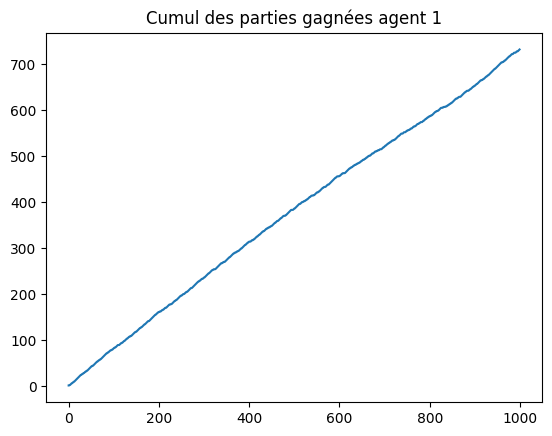

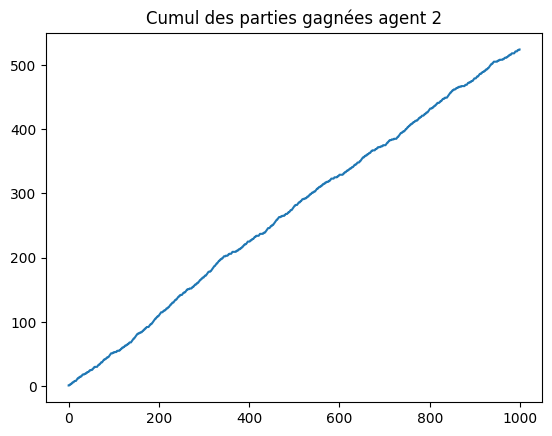

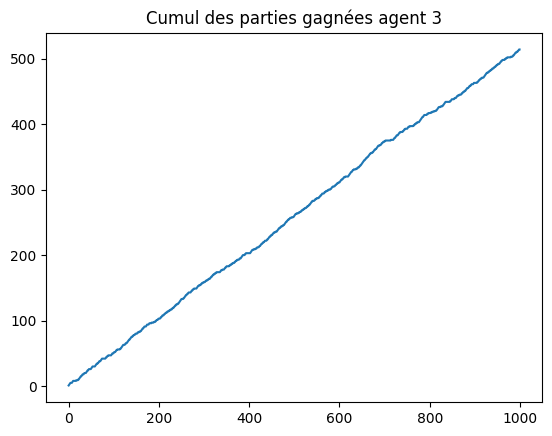

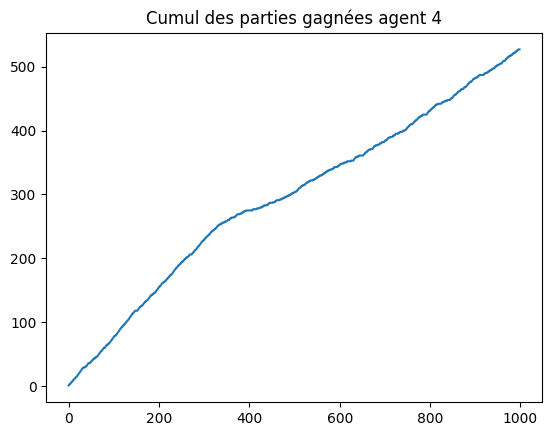

In [106]:
# print("Number of won games during training:", won_games, "/", N_episodes, "\n")
plt.title("Cumul des parties gagnées agent 1")
plt.plot(cumulated_won_games[0])
plt.show()

plt.title("Cumul des parties gagnées agent 2")
plt.plot(cumulated_won_games[1])
plt.show()

plt.title("Cumul des parties gagnées agent 3")
plt.plot(cumulated_won_games[2])
plt.show()

plt.title("Cumul des parties gagnées agent 4")
plt.plot(cumulated_won_games[3])
plt.show()

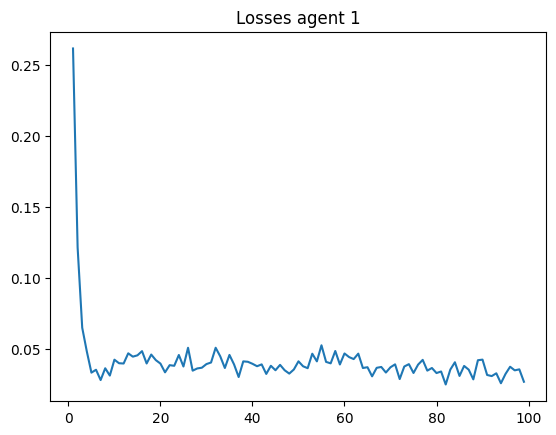

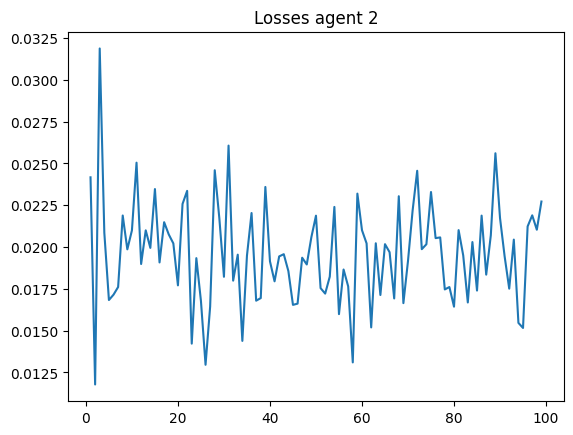

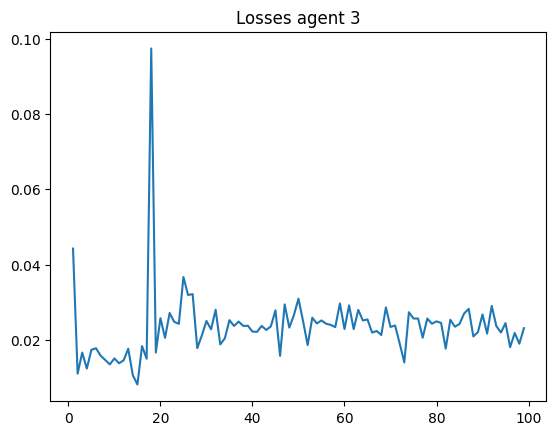

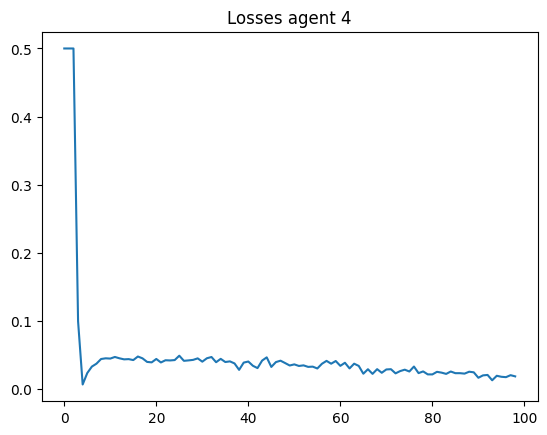

In [110]:
plt.plot(losses[0])
plt.title("Losses agent 1")
plt.show()

plt.plot(losses[1])
plt.title("Losses agent 2")
plt.show()

plt.plot(losses[2])
plt.title("Losses agent 3")
plt.show()

plt.plot([min(loss, 0.5) for loss in losses[3]])
plt.title("Losses agent 4")
plt.show()

In [108]:
# # Evaluate the final policy
# rewards_0 = eval_agent(agent0, agent_rd, env, 20)
# rewards_1 = eval_agent(agent_rd, agent0, env, 20)

# print("mean reward after training = ", rewards_0, "\n")
# print("mean reward after training = ", rewards_1)

# plt.hist([play_game(env, agent0, agent_rd, display=False) for _ in range(100)])
# plt.title("against random player")
# plt.show()
# plt.hist([play_game(env, agent0, agent_left, display=False) for _ in range(100)])
# plt.title("against left player")
# plt.show()
# plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
# plt.title("against other agent")
# plt.show()

# play_game(env, agent0=agent0, agent1=agent_rd, display=False)